## Given dataset is the weather details of Beijing city. Client has asked us to forecast the values of PRES (atmospheric pressure) for the next 30 days.
## Normal atmospheric pressure is 1013.25 millibars. This pressure will be low during summer season & high during winter season. SImply put as the temperature increases the atmospheric pressure decreases & when the atmospheric pressure comes down, it rains. After the rain, atmospheric pressure goes up becoz of low temperature.
## High pressure -> high density -> Sun -> density comes down -> pressure comes down

In [1]:
# Importing all the required libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from joblib import Parallel,delayed
from prophet import Prophet
from pmdarima import auto_arima

In [2]:
# Reading the data from a csv file from my local system
df=pd.read_csv('PRSA_data_2010.1.1-2014.12.31.csv')

In [3]:
# First 5 rows
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [4]:
# dimension of the dataset
df.shape

(43824, 13)

In [5]:
# Checking the number of unique values of 'No' column
df['No'].nunique()

43824

## The given dataset has many other values like pm2.5, dew point, temperature, combined wind direction, accumulated wind speed, accumulated no of hours of snow & accumulated no of hours of rain. 'No' is an identifier column. Since, we are concerned only about 'PRES', lets go ahead & drop all other variables apart from 'year','month', 'day' & 'hour'

In [6]:
# Extracting the list of all the columns in the dataset
df.columns

Index(['No', 'year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES',
       'cbwd', 'Iws', 'Is', 'Ir'],
      dtype='object')

In [7]:
# Dropping all the other columns
df.drop(columns=['No', 'pm2.5', 'DEWP', 'TEMP','cbwd', 'Iws', 'Is', 'Ir'],inplace=True)

In [8]:
# Checking the data again
df.head()

,year,month,day,hour,PRES
0,2010,1,1,0,1021.0
1,2010,1,1,1,1020.0
2,2010,1,1,2,1019.0
3,2010,1,1,3,1019.0
4,2010,1,1,4,1018.0


In [9]:
# Statistical summary of the data
df.describe()

,year,month,day,hour,PRES
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,2012.000000,6.523549,15.727820,11.500000,1016.447654
std,1.413842,3.448572,8.799425,6.922266,10.268698
min,2010.000000,1.000000,1.000000,0.000000,991.000000
25%,2011.000000,4.000000,8.000000,5.750000,1008.000000
50%,2012.000000,7.000000,16.000000,11.500000,1016.000000
75%,2013.000000,10.000000,23.000000,17.250000,1025.000000
max,2014.000000,12.000000,31.000000,23.000000,1046.000000


In [10]:
# Basic info of all the variables in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    43824 non-null  int64  
 1   month   43824 non-null  int64  
 2   day     43824 non-null  int64  
 3   hour    43824 non-null  int64  
 4   PRES    43824 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 1.7 MB


In [11]:
df[df['year']==2014].describe()

,year,month,day,hour,PRES
count,8760.0,8760.000000,8760.000000,8760.000000,8760.000000
mean,2014.0,6.526027,15.720548,11.500000,1016.637557
std,0.0,3.448048,8.796749,6.922582,9.797063
min,2014.0,1.000000,1.000000,0.000000,993.000000
25%,2014.0,4.000000,8.000000,5.750000,1008.000000
50%,2014.0,7.000000,16.000000,11.500000,1016.000000
75%,2014.0,10.000000,23.000000,17.250000,1025.000000
max,2014.0,12.000000,31.000000,23.000000,1039.000000


In [12]:
# Calculating the total no of hours for 5 years
(24*365) + (24*365) + (24*366) + (24*365) + (24*365)

43824

## We are now left with 5 columns, 1 - year, 2 - month in a year, 3 - day of the month, 4 - hour of the day & 5 - atmospheric pressure values recorded at the end of that hour

## Initial observations about the data
### 1. There are five columns in the dataset - 4 are integer types & 1 is float type
### 2. Dataset has a total of 43824 observations
### 3. Data is collected over a period from 2010 to 2014 i.e. every hour of every day of every month in 2010 to every hour of every day of every month in 2014. So, total data if for full 5 years

In [13]:
# Checking to know if 'PRES' column is actually of float type & it says it should be the way it is.
isinteger = df['PRES']/1 == 0
if isinteger.any():
    print('Pressure should be integer column')
else:
    print('It is right as it is')

It is right as it is


In [14]:
# Extracting the unique values of 'PRES' to see if there are any float values & yes, there are few real float values, 
# Hence it is right as is
df['PRES'].unique()

array([1021.      , 1020.      , 1019.      , 1018.      , 1017.      ,
       1015.      , 1014.      , 1016.      , 1022.      , 1023.      ,
       1024.      , 1025.      , 1026.      , 1027.      , 1028.      ,
       1029.      , 1030.      , 1031.      , 1032.      , 1033.      ,
       1034.      , 1035.      , 1036.      , 1037.      , 1038.      ,
       1039.      , 1013.      , 1012.      , 1011.      , 1010.      ,
       1009.      , 1008.      , 1007.      , 1006.      , 1004.      ,
       1003.      , 1002.      , 1005.      , 1040.      , 1041.      ,
       1042.      , 1001.      , 1000.      ,  999.      ,  997.      ,
        996.      ,  998.      ,  995.      ,  994.      , 1043.      ,
       1019.5     , 1029.666667, 1032.333333, 1044.      , 1045.      ,
        993.      ,  992.      , 1046.      , 1027.5     ,  991.      ])

### Since the data has close to 43k rows, visualizing could be a challenge. Hence, going ahead with aggregation of the pressure values day wise. We are going to use mean values of 'PRES' of a day

In [15]:
# Extracting only the unique rows from the dataset containing only year, month & day
df.drop(columns=['hour','PRES']).drop_duplicates(keep='first')

,year,month,day
0,2010,1,1
24,2010,1,2
48,2010,1,3
72,2010,1,4
96,2010,1,5
...,...,...,...
43704,2014,12,27
43728,2014,12,28
43752,2014,12,29
43776,2014,12,30


In [16]:
# Storing the same in a variable called 'interim_df'
linear_df=df.drop(columns=['hour','PRES']).drop_duplicates(keep='first').reset_index(drop=True)

In [17]:
# Calculating the mean 'PRES' values day wise for that month & year
df.groupby(['year','month','day'])['PRES'].mean()

year  month  day
2010  1      1      1017.083333
             2      1024.750000
             3      1022.791667
             4      1029.291667
             5      1033.625000
                       ...     
2014  12     27     1027.833333
             28     1019.958333
             29     1013.750000
             30     1019.125000
             31     1032.125000
Name: PRES, Length: 1826, dtype: float64

In [18]:
# Creating another column called 'pressure' in interim_df
linear_df['pressure']=df.groupby(['year','month','day'])['PRES'].mean().values

In [19]:
# Checking if the changes are done
linear_df.head()

,year,month,day,pressure
0,2010,1,1,1017.083333
1,2010,1,2,1024.750000
2,2010,1,3,1022.791667
3,2010,1,4,1029.291667
4,2010,1,5,1033.625000


In [20]:
# Preserving a copy of df for other models to use
fb_df=linear_df.copy()
ets_df=linear_df.copy()

In [21]:
# Checking the shape of the aggregated dataframe or 'ets_df' that we will consider as the final dataset on which analysis needs 
# to be made
ets_df.shape

(1826, 4)

### After the aggregation, final observations have come down to 1826 & the analysis needs to be made on this dataset
### As we all know for Time Series Analysis, date column needs to be as an index of the dataset. Hence, make the changes accordingly

In [22]:
ets_df.head()

,year,month,day,pressure
0,2010,1,1,1017.083333
1,2010,1,2,1024.750000
2,2010,1,3,1022.791667
3,2010,1,4,1029.291667
4,2010,1,5,1033.625000


In [23]:
linear_df.head()

,year,month,day,pressure
0,2010,1,1,1017.083333
1,2010,1,2,1024.750000
2,2010,1,3,1022.791667
3,2010,1,4,1029.291667
4,2010,1,5,1033.625000


In [24]:
fb_df.head()

,year,month,day,pressure
0,2010,1,1,1017.083333
1,2010,1,2,1024.750000
2,2010,1,3,1022.791667
3,2010,1,4,1029.291667
4,2010,1,5,1033.625000


In [25]:
# Creating a new column called 'date' so that this column can be added as an index of the dataset
ets_df['date']=pd.to_datetime(ets_df[['year','month','day']])

In [26]:
# Checking for the changes
ets_df.head()

,year,month,day,pressure,date
0,2010,1,1,1017.083333,2010-01-01
1,2010,1,2,1024.750000,2010-01-02
2,2010,1,3,1022.791667,2010-01-03
3,2010,1,4,1029.291667,2010-01-04
4,2010,1,5,1033.625000,2010-01-05


In [27]:
# Since we have the data of the year, month & day, dropping these columns
ets_df.drop(columns=['year','month','day'],inplace=True)

In [28]:
# Checking for the changes
ets_df.head()

,pressure,date
0,1017.083333,2010-01-01
1,1024.750000,2010-01-02
2,1022.791667,2010-01-03
3,1029.291667,2010-01-04
4,1033.625000,2010-01-05


In [29]:
# Setting date as the index of the dataset
ets_df=ets_df.set_index('date')

In [30]:
# Setting the freq of the dates as "Daily"
ets_df=ets_df.asfreq('D')

In [31]:
# Checking for the changes
ets_df.head()

,pressure
date,
2010-01-01,1017.083333
2010-01-02,1024.750000
2010-01-03,1022.791667
2010-01-04,1029.291667
2010-01-05,1033.625000


In [32]:
# Decomposing the data into its constituents
decom=seasonal_decompose(ets_df['pressure'])

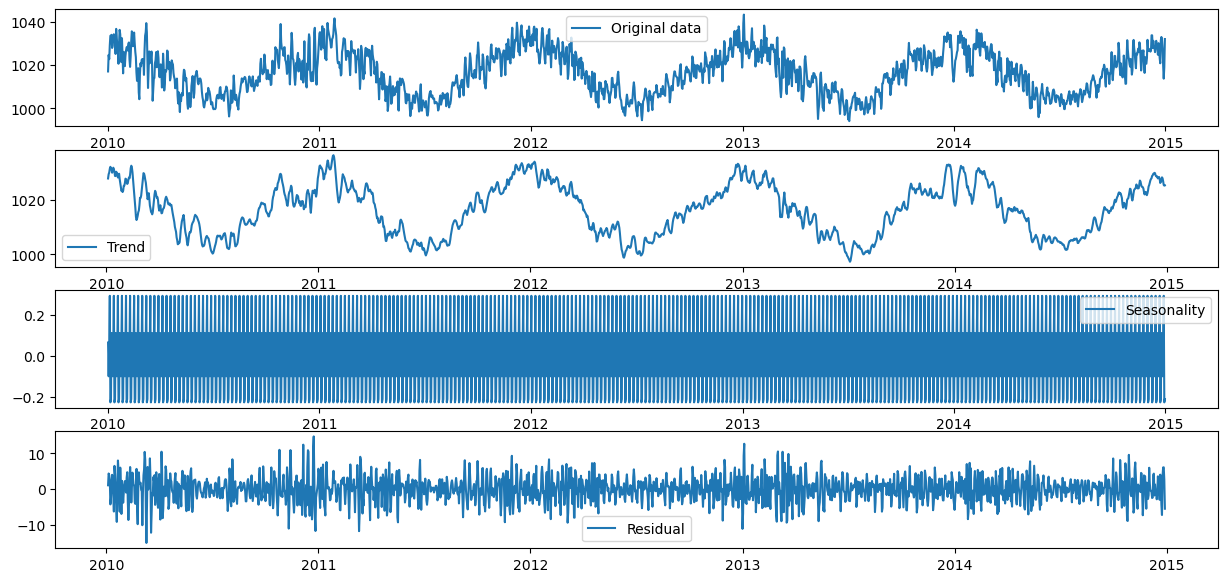

In [33]:
# Plotting all of its constituents
plt.figure(figsize=(15,7))
plt.subplot(411)
plt.plot(decom.observed,label='Original data')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decom.trend,label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decom.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decom.resid,label='Residual')
plt.legend(loc='best');

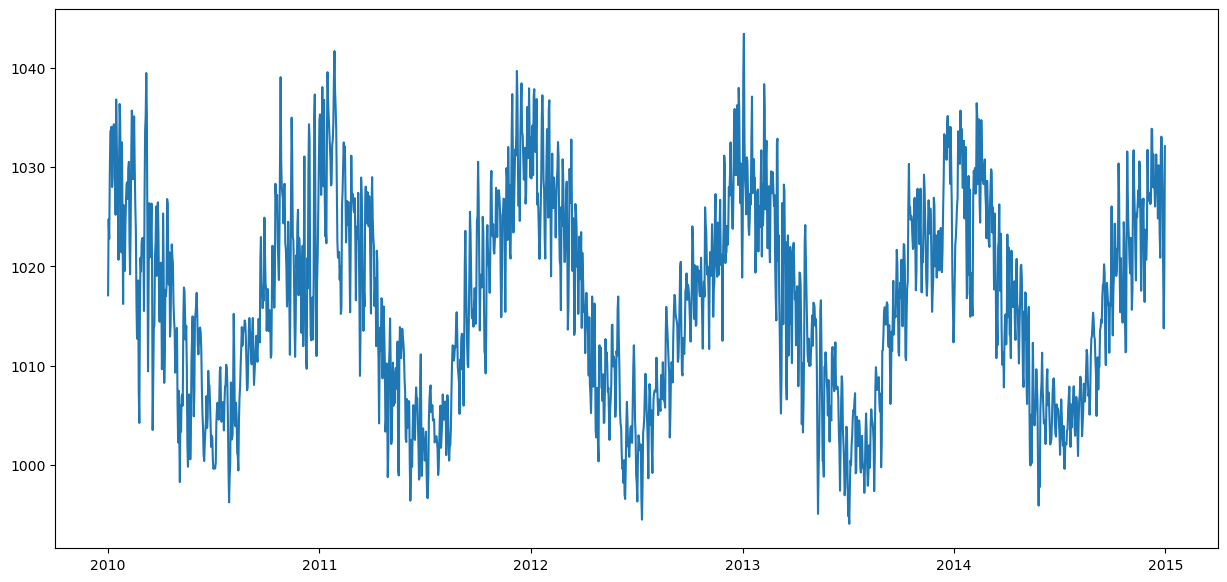

In [34]:
# Visualizing the target 'pressure'
plt.figure(figsize=(15,7))
plt.plot(ets_df['pressure']);

### Data Observations
### 1. As we can notice, there's a seasonality component in the dataset.
### 2. Lowest pressure is recorded between 'June', 'July' & sometimes 'Aug' months as it is summer.
### 3. Highest pressure is noticed during 'Dec', 'Jan' & 'Feb' months as it is winter.
### 4. To summarize, we can notice that as the temperature decreases beyond July & Aug, pressure is increasing
### 5. There's a cylical behavior in trend

## Pre-processing

In [35]:
# Checking for missing values
ets_df.isnull().sum()

pressure    0
dtype: int64

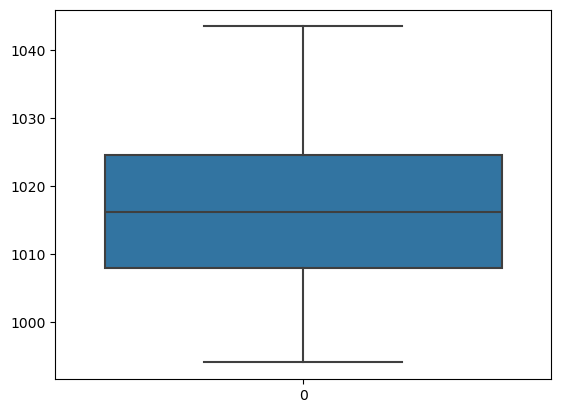

In [36]:
# Checking for outliers
sns.boxplot(ets_df['pressure']);

In [37]:
# Checking for duplicates - But it cannot be done on this dataset as it has only one column that is 'pressure' & it's values are
# repeating. Hence, it will not make any sense. So, lets check the duplicacy on interim_df which is like the parent of this 
# dataset
linear_df[linear_df.duplicated()]

,year,month,day,pressure


In [38]:
# linear_df.head()

### Pre-processing observations
### 1. There are no missing values in the data
### 2. There are no outliers in the data
### 3. There are no duplicates in the data
### 4. Encoding & scaling are not necessary here

## Checking for stationarity (constant mean & constant variance) using adfuller test

### By observing the original plot & the decomposed plots itself we can conclude that the data in non-stationary however lets use adfuller test to re-confirm it

In [39]:
# adfuller test to check the stationarity & the result is a list whose 2nd item is p-value
adfuller(ets_df['pressure'])[1]

0.03523346637114593

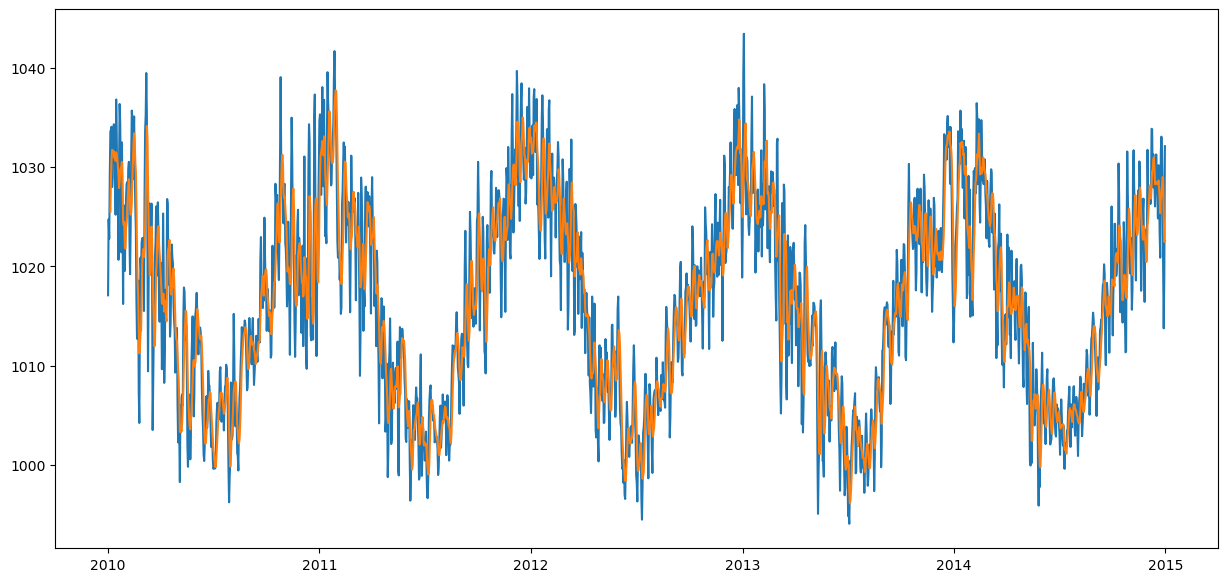

In [40]:
plt.figure(figsize=(15,7))
plt.plot(ets_df['pressure'])
plt.plot(ets_df['pressure'].rolling(window=5).mean());
# plt.plot(df['pressure'].rolling(window=5).std());

## By looking at the plot, I had come to a conclusion that there's seasonality & trend in the data as there were repeated cyclical behavior however I forgot the range in the 'pressure' values. The difference between min & max value is just 50 odd. Within this difference range, the non-stationarity that I observed, might be a weak stationarity. 
## Value that was generated out of adfuller test is called the 'p-value' & since it less than 0.05 (significance level), we reject the null hypothesis. Null hypothesis states that the data is non-stationary & alternate hypothesis states that the data is stationary.
## Hence, as per the adfuller test, it is clear that the data is stationary. Consequently, there's no differencing required for this data.

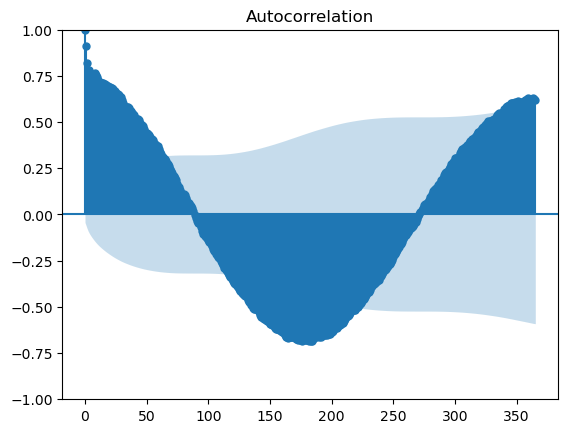

In [41]:
plot_acf(ets_df['pressure'],lags=365);

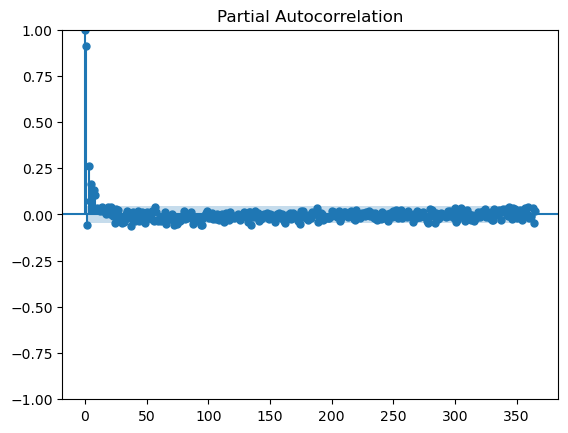

In [42]:
plot_pacf(ets_df['pressure'],lags=365);

### As the dataset is quite big, drawing inferences (the order terms of SARIMA model), from acf & pacf plots can be a challenge. So, will use other models for forecasting

In [43]:
# Train-test-split (80% - 20%)
train_data=ets_df.iloc[:1460,:]
test_data=ets_df.iloc[1460:,:]

In [44]:
train_data.shape

(1460, 1)

In [45]:
test_data.shape

(366, 1)

In [46]:
train_data.head()

,pressure
date,
2010-01-01,1017.083333
2010-01-02,1024.750000
2010-01-03,1022.791667
2010-01-04,1029.291667
2010-01-05,1033.625000


In [47]:
test_data.head()

,pressure
date,
2013-12-31,1012.333333
2014-01-01,1014.458333
2014-01-02,1018.333333
2014-01-03,1022.125000
2014-01-04,1022.875000


### Triple Exponential Smoothing (TES)

### Grid Search for ETS with Hyperparameters & Smoothing parameters. Since Grid Search CV won't support time series models, built my own Grid Search

In [48]:
# defining sort of "param_grid" containing both hyperparameters & smoothing parameters
damped_trend_options=[True,False]
trend_options=['add','mul']
seasonal_options=['add','mul']
initialization_method_options=[None,'estimated']
smoothing_level_values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
smoothing_trend_values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
smoothing_seasonal_values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

In [49]:
# Custom defined Grid Search
best_aic = np.inf
best_hyperparameter = None
best_smoothing_parameter = None

def fit_model_and_test(tdata,trend, seasonal, damped_trend, initialization_method, smoothing_level, smoothing_trend, smoothing_seasonal):
    model = ExponentialSmoothing(tdata,damped_trend=damped_trend, trend=trend, seasonal=seasonal, initialization_method=initialization_method)
    results = model.fit(smoothing_level=smoothing_level, smoothing_trend=smoothing_trend, smoothing_seasonal=smoothing_seasonal)
    aic = results.aic
    return aic, (trend, seasonal, damped_trend, initialization_method), (smoothing_level, smoothing_trend, smoothing_seasonal)

tss=TimeSeriesSplit(n_splits=5)

total_aic_scores=[]

for train_idx,val_idx in tss.split(train_data):
    tdata=train_data.iloc[train_idx]
    vdata=train_data.iloc[val_idx]

    results = Parallel(n_jobs=-1)(delayed(fit_model_and_test)(tdata,
    trend, seasonal, damped_trend, initialization_method, smoothing_level, smoothing_trend, smoothing_seasonal) 
    for trend in trend_options for seasonal in seasonal_options for damped_trend in damped_trend_options for initialization_method in initialization_method_options
    for smoothing_level in smoothing_level_values for smoothing_trend in smoothing_trend_values for smoothing_seasonal in smoothing_seasonal_values)

    for aic, hyperparameters, smoothing_parameters in results:
        if aic < best_aic:
            best_aic = aic
            best_hyperparameter = hyperparameters
            best_smoothing_parameter = smoothing_parameters
    total_aic_scores.append(best_aic)
    print(total_aic_scores)
    print("----- END OF THE FOLD -----")

print(best_aic)
print(best_hyperparameter)
print(best_smoothing_parameter)
print(np.mean(total_aic_scores))

[808.7917122051717]
----- END OF THE FOLD -----
[808.7917122051717, 808.7917122051717]
----- END OF THE FOLD -----
[808.7917122051717, 808.7917122051717, 808.7917122051717]
----- END OF THE FOLD -----
[808.7917122051717, 808.7917122051717, 808.7917122051717, 808.7917122051717]
----- END OF THE FOLD -----
[808.7917122051717, 808.7917122051717, 808.7917122051717, 808.7917122051717, 808.7917122051717]
----- END OF THE FOLD -----
808.7917122051717
('mul', 'mul', True, 'estimated')
(1.0, 0.1, 0.1)
808.7917122051717


In [50]:
# Best hyperparameter & smoothing parameter values
print(best_hyperparameter)
print(best_smoothing_parameter)

('mul', 'mul', True, 'estimated')
(1.0, 0.1, 0.1)


In [51]:
# Building ETS with the best hyperparameter & smoothing parameters
model=ExponentialSmoothing(train_data,trend='mul',seasonal='mul',initialization_method='heuristic',damped_trend=True,seasonal_periods=365)
results=model.fit(smoothing_level=1.0,smoothing_trend=0.1,smoothing_seasonal=0.1)
test_predictions=results.forecast(len(test_data))

In [52]:
# Mean Squared Error
metrics.mean_squared_error(test_data,test_predictions)

303.07170666205434

In [53]:
# Mean Absolute Error
metrics.mean_absolute_error(test_data,test_predictions)

16.522615972688136

In [54]:
# Root Mean Squared Error
np.sqrt(metrics.mean_squared_error(test_data,test_predictions))

17.408954783732835

In [55]:
# Predictions
predictions=results.forecast(396)

In [56]:
# Printing the predictions
predictions.tail(30)

2015-01-01     999.984093
2015-01-02    1007.266386
2015-01-03    1011.072060
2015-01-04    1009.845807
2015-01-05    1014.230154
2015-01-06    1013.192307
2015-01-07    1010.088119
2015-01-08    1014.877916
2015-01-09    1013.678849
2015-01-10    1012.392318
2015-01-11    1007.998677
2015-01-12    1007.667693
2015-01-13    1010.559998
2015-01-14    1014.042060
2015-01-15    1011.509709
2015-01-16    1013.283852
2015-01-17    1015.170239
2015-01-18    1012.676925
2015-01-19    1015.977460
2015-01-20    1016.273289
2015-01-21    1014.310976
2015-01-22    1013.115899
2015-01-23    1009.825176
2015-01-24    1011.275184
2015-01-25    1011.108562
2015-01-26    1014.483804
2015-01-27    1016.057951
2015-01-28    1014.140017
2015-01-29    1013.508762
2015-01-30    1010.611168
Freq: D, dtype: float64

### Since it is a daily data & extracting the order from visual inspection & running auto_arima could be a challenge. Hence proceeding with other advanced algorithms like fbprophet

### FBProphet

In [57]:
fb_df

,year,month,day,pressure
0,2010,1,1,1017.083333
1,2010,1,2,1024.750000
2,2010,1,3,1022.791667
3,2010,1,4,1029.291667
4,2010,1,5,1033.625000
...,...,...,...,...
1821,2014,12,27,1027.833333
1822,2014,12,28,1019.958333
1823,2014,12,29,1013.750000
1824,2014,12,30,1019.125000


In [58]:
# Preparing the data for prophet - creating a new column for 'ds' which contains the date column
fb_df['ds']=pd.to_datetime(fb_df[['year','month','day']])

In [59]:
# checking for the changes
fb_df.head()

,year,month,day,pressure,ds
0,2010,1,1,1017.083333,2010-01-01
1,2010,1,2,1024.750000,2010-01-02
2,2010,1,3,1022.791667,2010-01-03
3,2010,1,4,1029.291667,2010-01-04
4,2010,1,5,1033.625000,2010-01-05


In [60]:
# Dropping year, month & day column from the dataset
fb_df.drop(columns=['year','month','day'],inplace=True)

In [61]:
# Checking for the changes
fb_df.head()

,pressure,ds
0,1017.083333,2010-01-01
1,1024.750000,2010-01-02
2,1022.791667,2010-01-03
3,1029.291667,2010-01-04
4,1033.625000,2010-01-05


In [62]:
# Renaming the target i.e. 'pressure' as 'y' - this is required by the model that the target should be named 'y' & the
# date column should be named 'ds'
fb_df.rename(columns={'pressure':'y'},inplace=True)

In [63]:
# Checking for the changes
fb_df.head()

,y,ds
0,1017.083333,2010-01-01
1,1024.750000,2010-01-02
2,1022.791667,2010-01-03
3,1029.291667,2010-01-04
4,1033.625000,2010-01-05


In [64]:
# Initializing these variables
prophet_rmse_scores=[]
best_rmse=np.inf
best_combo=None

In [65]:
# Splitting the dataset into train & test data
fb_train_data=fb_df.iloc[:1461]
fb_test_data=fb_df.iloc[1461:]

In [66]:
# Checking for the changes
fb_train_data.head()

,y,ds
0,1017.083333,2010-01-01
1,1024.750000,2010-01-02
2,1022.791667,2010-01-03
3,1029.291667,2010-01-04
4,1033.625000,2010-01-05


In [67]:
# checking for the changes
fb_test_data.head()

,y,ds
1461,1014.458333,2014-01-01
1462,1018.333333,2014-01-02
1463,1022.125000,2014-01-03
1464,1022.875000,2014-01-04
1465,1024.291667,2014-01-05


In [68]:
# Checking for best value for the hyperparameter 'seasonality_mode'
for seasonality_mode in ['additive','multiplicative']:
    model=Prophet(seasonality_mode=seasonality_mode)
    results=model.fit(fb_train_data)
    future=results.make_future_dataframe(periods=len(fb_test_data))
    future = future.iloc[fb_test_data.index[0]:]
    predictions=results.predict(future)
    rmse=np.sqrt(metrics.mean_squared_error(fb_test_data['y'],predictions['trend']))
    prophet_rmse_scores.append([rmse,(seasonality_mode)])

09:19:14 - cmdstanpy - INFO - Chain [1] start processing
09:19:15 - cmdstanpy - INFO - Chain [1] done processing
09:19:15 - cmdstanpy - INFO - Chain [1] start processing
09:19:16 - cmdstanpy - INFO - Chain [1] done processing


In [69]:
# multiplicative is best value for seasonality_mode
prophet_rmse_scores

[[9.619780778855155, 'additive'], [9.618846276063682, 'multiplicative']]

In [70]:
# Building the model with multiplicative seasonality_mode
model=Prophet(seasonality_mode='multiplicative')
results=model.fit(fb_df)
future=results.make_future_dataframe(30)

09:19:16 - cmdstanpy - INFO - Chain [1] start processing
09:19:16 - cmdstanpy - INFO - Chain [1] done processing


In [71]:
# forecasting for test data
future=future.iloc[fb_test_data.index[0]:]
predictions=results.predict(future)

In [72]:
# checking the predictions
predictions

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2014-01-01,1016.067720,1021.716221,1034.743721,1016.067720,1016.067720,0.012149,0.012149,0.012149,-0.000164,-0.000164,-0.000164,0.012313,0.012313,0.012313,0.0,0.0,0.0,1028.411664
1,2014-01-02,1016.071161,1022.783230,1034.780987,1016.071161,1016.071161,0.012571,0.012571,0.012571,0.000141,0.000141,0.000141,0.012430,0.012430,0.012430,0.0,0.0,0.0,1028.844415
2,2014-01-03,1016.074602,1022.686003,1035.232643,1016.074602,1016.074602,0.012591,0.012591,0.012591,0.000046,0.000046,0.000046,0.012546,0.012546,0.012546,0.0,0.0,0.0,1028.868503
3,2014-01-04,1016.078044,1022.907710,1034.802779,1016.078044,1016.078044,0.012560,0.012560,0.012560,-0.000096,-0.000096,-0.000096,0.012656,0.012656,0.012656,0.0,0.0,0.0,1028.840393
4,2014-01-05,1016.081485,1022.779873,1035.355855,1016.081485,1016.081485,0.012808,0.012808,0.012808,0.000048,0.000048,0.000048,0.012759,0.012759,0.012759,0.0,0.0,0.0,1029.095350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,2015-01-26,1017.409832,1023.502244,1035.528230,1017.336756,1017.477594,0.011655,0.011655,0.011655,0.000253,0.000253,0.000253,0.011402,0.011402,0.011402,0.0,0.0,0.0,1029.267483
391,2015-01-27,1017.413273,1022.154556,1035.022159,1017.328416,1017.486601,0.011003,0.011003,0.011003,-0.000229,-0.000229,-0.000229,0.011232,0.011232,0.011232,0.0,0.0,0.0,1028.607852
392,2015-01-28,1017.416715,1021.892533,1034.998568,1017.313612,1017.496942,0.010905,0.010905,0.010905,-0.000164,-0.000164,-0.000164,0.011069,0.011069,0.011069,0.0,0.0,0.0,1028.511777
393,2015-01-29,1017.420156,1022.288818,1035.024882,1017.298902,1017.507655,0.011057,0.011057,0.011057,0.000141,0.000141,0.000141,0.010916,0.010916,0.010916,0.0,0.0,0.0,1028.669681


In [73]:
# Checking the forecast, the upper range & the lower range
predictions[['trend_lower','trend','trend_upper']]

,trend_lower,trend,trend_upper
0,1016.067720,1016.067720,1016.067720
1,1016.071161,1016.071161,1016.071161
2,1016.074602,1016.074602,1016.074602
3,1016.078044,1016.078044,1016.078044
4,1016.081485,1016.081485,1016.081485
...,...,...,...
390,1017.336756,1017.409832,1017.477594
391,1017.328416,1017.413273,1017.486601
392,1017.313612,1017.416715,1017.496942
393,1017.298902,1017.420156,1017.507655


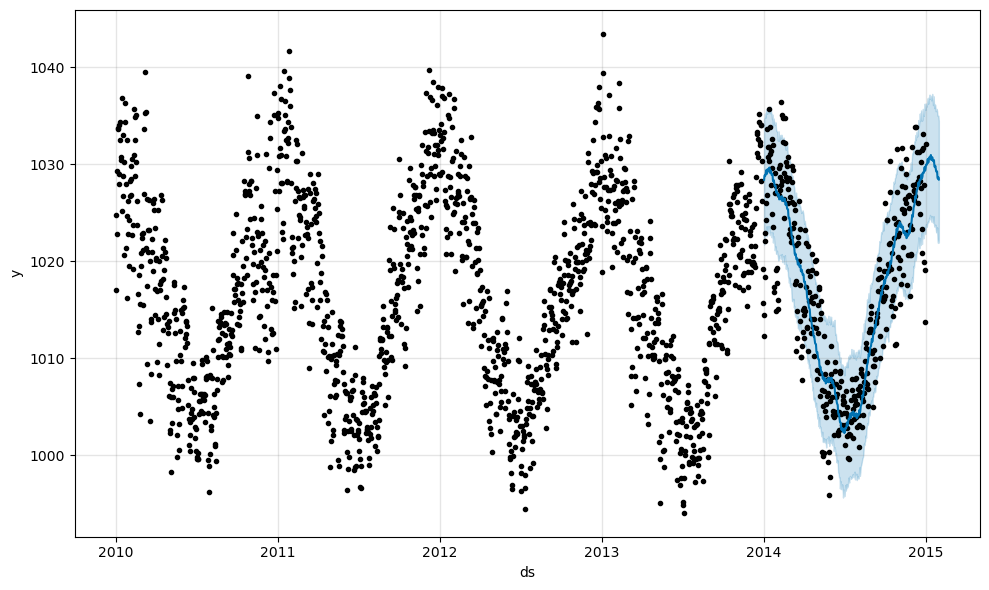

In [74]:
# Plotting the whole predictions
results.plot(predictions);

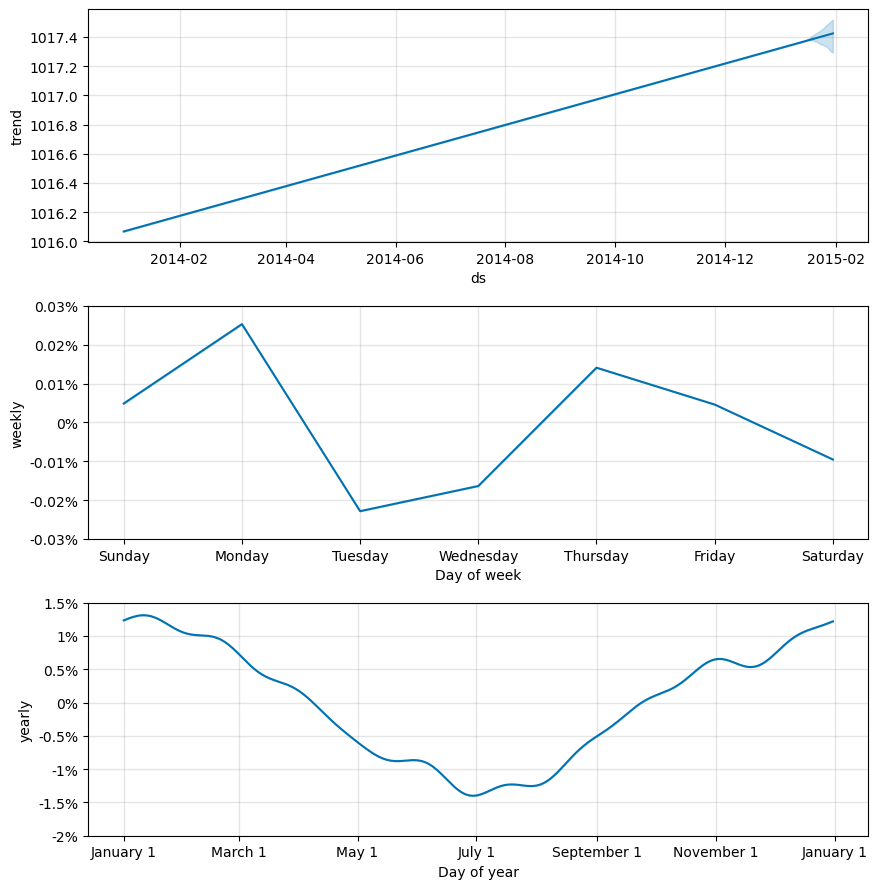

In [75]:
# Plotting the components of predictions individually
results.plot_components(predictions);

### These plots gives us the good forecast & even the analysis is good! It has captured the exact trend.